In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import site
import numpy as np
import pandas as pd

In [2]:
site.addsitedir('/mnt/home/agabrielpillai/github/') 
import illustris_sam as ilsam

In [3]:
basePath = '/mnt/ceph/users/agabrielpillai/camels_sam/hdf5/CV/CV_0/'

# linkprop and histprop

We set up everything like the previous examples. In this example we are loading and plotting star formation histories (SFHs) for producing SEDs and photometry. To do this, we use `ilsam.photo`. There are two structures we can load with this module. The first is `linkprop`, which contains linking information between `galprop` and `histprop`.

In [4]:
ilsam.photocat.load_linkprop(basePath, [0, 0, 0], fields=None)

{'LinkpropGalpropIndex': array([     97,      98,      99, ..., 1714533, 1714534, 1714535],
       dtype=uint32),
 'LinkpropRedshift': array([0.674116 , 0.647555 , 0.621429 , ..., 0.0233739, 0.0113166,
        0.       ], dtype=float32),
 'LinkpropSnapNum': array([60, 61, 62, ..., 97, 98, 99], dtype=uint32)}

The most 'important' one is the field LinkpropGalpropIndex which will allow you to index back into the galprop file for the entire subvolume (note: LinkpropGalpropIndex_Snapshot coming soon). 

Let's look at the keys in histprop.

In [5]:
SAM_photometry = ilsam.photocat.load_histprop(basePath, [0, 0, 0])
SAM_photometry.keys()

dict_keys(['HistpropNormFactor', 'HistpropSFHtuple', 'HistpropZtuple'])

Optimized for dense basis. HistpropSFHtuple is the compressed star formation history, HistpropZtuple is the compressed metallicity history. 

# Reconstructing SFHs with dense-basis 

Setting up dense basis ... 

In [6]:
%env SPS_HOME=/mnt/home/agabrielpillai/fsps
import dense_basis as db

env: SPS_HOME=/mnt/home/agabrielpillai/fsps
Starting dense_basis. please wait ~ a minute for the FSPS backend to initialize.


In [7]:
SAM_SFHs_80 = ilsam.photocat.load_histprop(basePath, [0, 0, 0])
SAM_links_80 = ilsam.photocat.load_linkprop(basePath, [0, 0, 0])

In [8]:
from sfhist_postprocess_fns import *

from astropy.cosmology import FlatLambdaCDM
db.cosmo = FlatLambdaCDM(H0=67.74, Om0=0.3089)

In [9]:
db.cosmo 

FlatLambdaCDM(H0=67.74 km / (Mpc s), Om0=0.3089, Tcmb0=0.0 K, Neff=3.04, m_nu=None, Ob0=None)

In [10]:
sfhtuple = SAM_SFHs_80['HistpropSFHtuple'][0, :]
Ztuple = SAM_SFHs_80['HistpropZtuple'][0, :]
norm_fac = SAM_SFHs_80['HistpropNormFactor'][0]

zval = SAM_links_80['LinkpropRedshift'][0] + 0.03

In [11]:
tempsfh, tempZt, timeax = uncompress_sfh(np.array(sfhtuple), np.array(Ztuple), 
                                         zval, db.cosmo , interpolator='pchip')

# Creating SEDs with dense-basis and FSPS

First a look at the default available filters ... 

In [12]:
addlines = False
db.mocksp._zcontinuous = 1
db.mocksp.params['sfh'] = 3
db.mocksp.params['cloudy_dust'] = False
db.mocksp.params['gas_logu'] = -2
db.mocksp.params['add_igm_absorption'] = False
db.mocksp.params['add_neb_emission'] = addlines
db.mocksp.params['add_neb_continuum'] = addlines
db.mocksp.params['imf_type'] = 1 # Chabrier
db.mocksp.params['dust2'] = 0.0

In [13]:
lam, spec_comp = makespec_fast(tempsfh, tempZt, timeax, zval, cosmo=db.cosmo, interpolator='pchip')


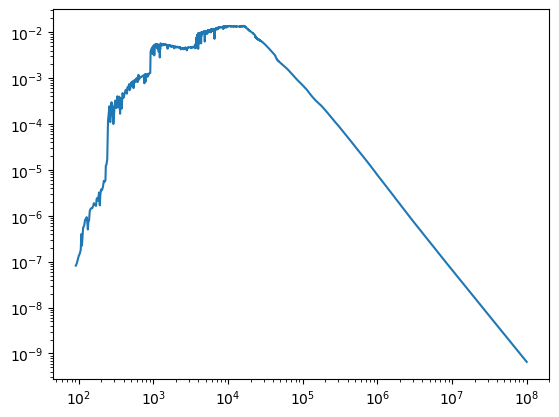

In [15]:
plt.plot(lam, spec_comp)
plt.yscale('log')
plt.xscale('log')

## Photometry

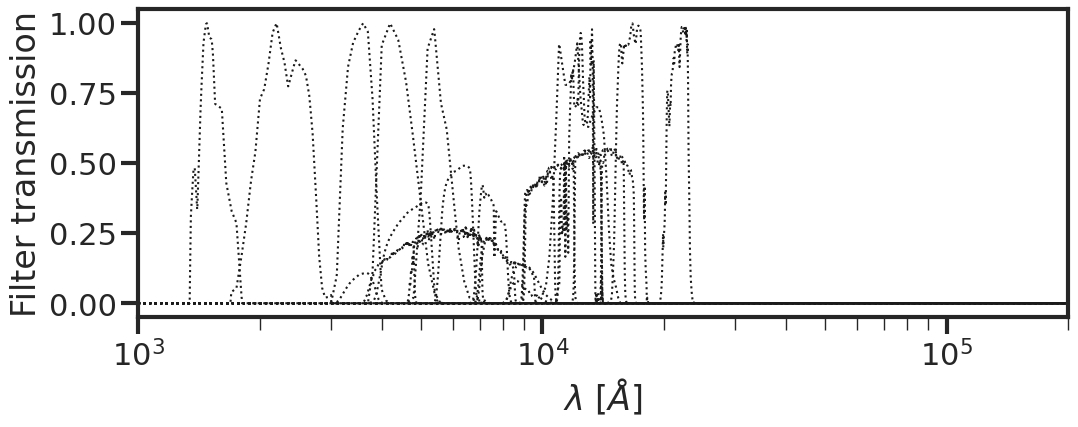

In [16]:
filter_list = 'filter_list_ltu.dat.txt'
filt_dir = '../data/filter_curves/'
db.plot_filterset(filter_list, filt_dir)

filter_names = ['FUV','NUV', # GALEX
                'Johnson U','Johnson B','Johnson V','Johnson J',
                'u','g','r','i','z', # SDSS 
                'J','H','Ks', # 2MASS
                'F435w','F606w','F775w','F814w','F850lp','F098m','F105w','F110w','F125w','F140w','F160w'] # HST 

In [17]:
filcurves, _, _ = db.make_filvalkit_simple(lam, zval, fkit_name = filter_list, filt_dir = filt_dir)


In [18]:
sed_comp = np.array(db.calc_fnu_sed_fast(spec_comp * norm_fac, filcurves))


In [19]:
sed_comp

array([0.00255522, 0.00533594, 0.00491262, 0.00461377, 0.00562883,
       0.01229618, 0.00491066, 0.00465475, 0.006661  , 0.0097851 ,
       0.01080019, 0.01251148, 0.01398669, 0.01393045, 0.00461382,
       0.00734173, 0.00990409, 0.01023091, 0.01095322, 0.01146459,
       0.01178153, 0.01197185, 0.0124    , 0.01285972, 0.0137621 ])

In [20]:
np.load('/mnt/ceph/users/agabrielpillai/sc-sam/tng-sam/classic/CAMELS_SAM/CV_0/samout/0_0_0/TEMP.photo.n10.001.npy')[0, :]

array([0.00255522, 0.00533594, 0.00491262, 0.00461377, 0.00562883,
       0.01229618, 0.00491066, 0.00465475, 0.006661  , 0.0097851 ,
       0.01080019, 0.01251148, 0.01398669, 0.01393045, 0.00461382,
       0.00734173, 0.00990409, 0.01023091, 0.01095322, 0.01146459,
       0.01178153, 0.01197185, 0.0124    , 0.01285972, 0.0137621 ])

# Creating SEDs with Synthesizer

# Dust modeling with ... 